# Functions and Imports for Ovarian Cancer Ratio Analysis

### Imports 
This includes transcriptional regulatory interactions from TRRUST v2 (https://www.grnpedia.org/trrust/downloadnetwork.php)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cptac
import cptac.algorithms as al
tf_data = pd.read_csv('/Users/amandaoliphant/Documents/GitHub/ProteinComplexes/Data_Files/trrust_rawdata.human.tsv', sep='\t', header=None)
tf_data.columns = ['TF', 'Regulated_Gene', 'Regulation_Type', 'ID']

## Initialize datasets

In [2]:
# Create a workable dictionary of protein complex information (all cancer types)
# Select for human complexes
complexData = pd.read_csv('/Users/amandaoliphant/Documents/GitHub/ProteinComplexes/Data_Files/allComplexes.txt', sep='\t')
complexData = complexData.loc[complexData['Organism'] == 'Human']

# Split the proteins in each complex into invdividual columns of a new df
subunitNames = complexData['subunits(Gene name)'].str.split(';', expand = True)
subunitNames.index = complexData.ComplexName

# Create a dictionary (key = complex name, value = list of proteins in complex) and remove None values
subunitNames = subunitNames.loc[~subunitNames.index.duplicated()]
subunitNames = subunitNames.transpose().to_dict('list')
for key, val in subunitNames.items():
    subunitNames[key] = [value for value in val if value != None]

# Ovarian Data

cptac.download(dataset='ovarian', version='latest')
ov = cptac.Ovarian()
ov_clinical = ov.get_clinical()
ov_mutations = ov.get_mutations()
ov_mutation_data = ov_clinical[['Patient_ID', 'Sample_Tumor_Normal']].join(ov_mutations).dropna(axis = 0)
ov_mutation_data = ov_mutation_data.loc[ov_mutation_data['Sample_Tumor_Normal'] == 'Tumor']

#Only for ovarian: Import non-normalized proteomics data for ratio analysis
data = pd.read_csv('/Users/amandaoliphant/Documents/GitHub/ProteinComplexes/Data_Files/proteinGroups_cleaned.txt', sep='\t')

# Remove duplicate rows from the dataset
data = data.set_index('Gene_Name')
data = data.loc[~data.index.duplicated()]

# Endometrial Data
cptac.download(dataset='endometrial', version='latest')
en = cptac.Endometrial()
en_clinical = en.get_clinical()
en_mutations = en.get_mutations()
en_mutation_data = en_clinical[['Patient_ID', 'Proteomics_Tumor_Normal']].join(en_mutations).dropna(axis = 0)
en_mutation_data = en_mutation_data.loc[en_mutation_data['Proteomics_Tumor_Normal'] == 'Tumor']

# Colon Data
cptac.download(dataset='colon', version='latest')
colon = cptac.Colon()
colon_clinical = colon.get_clinical()
colon_mutations = colon.get_mutations()
colon_mutation_data = colon_clinical[['Patient_ID', 'Sample_Tumor_Normal']].join(colon_mutations).dropna(axis = 0)
colon_mutation_data = colon_mutation_data.loc[colon_mutation_data['Sample_Tumor_Normal'] == 'Tumor']

# Renal Data
cptac.download(dataset='renalccrcc', version='latest')
renal = cptac.RenalCcrcc()

All files already downloaded and correct.
All files already downloaded and correct.
All files already downloaded and correct.
All files already downloaded and correct.


## Define basic analysis and plotting functions

### get_ratio_df

In [3]:
"""
get_ratio_df
-----------
All patients, single protein, tumor vs normal
Returns two dataframes: tumor and normal containing ratios for the proteins

Parameters:
    prot1, prot2 = (gene) names of the two proteins to be compared (ratio of prot1 / prot2)
    
Returns:
    Two dataframes: tumor and normal containing ratios for the proteins
  
"""
def get_ratio_df(prot1, prot2):
    # Make sure that both proteins are in our dataset
    if not data.index.contains(prot1) or not data.index.contains(prot2): return None, None
    
    # Create a dataframe of ratios for easy testing
    tumor_rows_list = []
    normal_rows_list = []
    for patient in data.columns:
        
        # Determine the sample type
        sample_type = 'Tumor'
        if '_NM' in patient: sample_type = 'Normal'
            
        # Find the ratio prot1 / prot2 and create a new row for the dataframe
        if data.at[prot2, patient] == 0: 
            ratio = np.nan
        else: 
            ratio = data.at[prot1, patient] / data.at[prot2, patient]
        # Create a row entry for the dictionary
        row_dict = {'Ratio': ratio, 'Sample_Type': sample_type, 'Patient_ID': patient}
        
        # Add the new row to the tumor or normal list, depending on the sample type
        if sample_type == 'Tumor':
            tumor_rows_list.append(row_dict)
        else:
            normal_rows_list.append(row_dict)
    
    # Convert the row lists into dataframes
    tumor_ratio_df = pd.DataFrame(tumor_rows_list)
    normal_ratio_df = pd.DataFrame(normal_rows_list)
    
    # If there were no valid ratios for either the tumor or normal samples, return None
    if (not np.isfinite(tumor_ratio_df['Ratio']).any()) or (not np.isfinite(normal_ratio_df['Ratio']).any()): 
        return None, None
    
    # Drop na values
    tumor_ratio_df = tumor_ratio_df.dropna(axis = 0)
    normal_ratio_df = normal_ratio_df.dropna(axis = 0)
    
    return tumor_ratio_df, normal_ratio_df

### test_complex

In [9]:
"""
test_complex
------------
Perform statistical tests on every combination of proteins in a given complex, printing those with significant p-values

Parameters:
    complex_name = name of the complex
    test_type = type of test to perform, levene or ttest
    
Returns:
    Classification of the complex: whether it has proteins missing in the normal, missing proteins in cancer,
    or other (proteins present in both)
    Prints tests with statistically significant values

"""
def test_complex(complex_name, test_type = 'ttest'):
    
    prot_list = subunitNames[complex_name]
    sig_result_found = False
    
    # Keep track of how many significant ratios in this complex include only 0 values for tumor/normal 
    num_missing_tumor = 0
    num_missing_normal = 0
    
    # Calculate the cutoff for significance (Bonferroni correction)
    alpha = 0.05 / (len(subunitNames)*(len(subunitNames) - 1))
    
    for i in range(0, len(prot_list)):
        for j in range(0, len(prot_list)):
            if j == i: continue
                
            # Test the two proteins (ratio of prot1 / prot2)
            tumor_ratio_df, normal_ratio_df = get_ratio_df(prot_list[i], prot_list[j])
            if tumor_ratio_df is None or normal_ratio_df is None: continue

            # Perform the selected statistical test on the ratios
            
            # If both tumor and normal only have 0 values for the ratio, the tests don't work
            if (sum(tumor_ratio_df['Ratio']) == 0) and (sum(normal_ratio_df['Ratio']) == 0): continue   
            # If there are not enough samples, the tests also don't work
            if (len(tumor_ratio_df) < 2) or (len(normal_ratio_df) < 2): continue
                
            if test_type == 'ttest':
                test_result = scipy.stats.ttest_ind(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]
            else:
                # This test throws a warning if the variance in both is 0, so we check for that
                if (np.var(tumor_ratio_df['Ratio']) == 0) and (np.var(normal_ratio_df['Ratio']) == 0): continue
                test_result = scipy.stats.levene(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]
            
            # If the p-value is significant, print the result and return the appropriate classification
            if test_result < alpha:
                sig_result_found = True
                # Determine the classification of this ratio
                if not (normal_ratio_df['Ratio'] != 0).any():
                    num_missing_normal += 1
                    print('Normal missing ' + prot_list[i] + ' / ' + prot_list[j])
                elif not (tumor_ratio_df['Ratio'] != 0).any():
                    num_missing_tumor += 1
                    print('Tumor missing ' + prot_list[i] + ' / ' + prot_list[j])
    
                print(prot_list[i] + ' / ' + prot_list[j] + ': ' + str(test_result))
                
    if sig_result_found: 
        
        print(complex_name)
        print('---------------------------')
        print('---------------------------')
        
        # Classify the complex as a whole depending on the classification of the majority of ratios
        # If none of the ratios had all 0 values for tumor or normal, it is classified as "Other"
        if num_missing_normal == 0 and num_missing_tumor == 0:
            return "Other"
        elif num_missing_normal >= num_missing_tumor:
            return "Normal Missing Proteins"
        elif num_missing_tumor > num_missing_normal:
            return "Tumor Missing Proteins"
        
    return "NS"

### test_all_complexes

In [4]:
"""
test_all_complexes
------------------
Test all complexes in the dataset for significance

Parameters:
    test_type (optional) = ttest or levene
    
Returns:
    A dictionary: {"Normal Missing Proteins": [List of complexes], 
    "Tumor Missing Proteins": [List of complexes], 
    "Other": [List of complexes]}
    
"""

def test_all_complexes(test_type = 'ttest'):
    
    if test_type != 'ttest' and test_type != 'levene':
        print("Error: test_type must equal 'ttest' or 'levene'")
        return
    
    classified_complexes = {"Normal Missing Proteins": [], "Tumor Missing Proteins": [], "Other": [], "NS": []}
    
    for key, val in subunitNames.items():
        complex_type = test_complex(key, test_type = test_type)
        classified_complexes[complex_type].append(key)
        
    return classified_complexes

### find_mutations

In [5]:
"""
find_mutations
--------------
Search mutational data for mutations in proteins that change in a complex or transcription factors
known to regulate said proteins

Parameters:
    complex_dict = dictionary of protein complexes (output of test_all_complexes)
    transcription_factors = if True, will test for mutations in transcription factors known to regulate
        proteins in the complex
        
Returns:
    Prints results (how many patients have mutations in the protein or transcription factor)

"""

def find_mutations(complex_dict, transcription_factors = False):
    
    for key, val in complex_dict.items():
        if key == 'NS': continue
        print(key)
        print('--------------')
        print('--------------')
        for complex_name in val:
            changed_proteins = []
            mutation_rate = {}

            # Calculate the cutoff for significance (Bonferroni correction)
            alpha = 0.05 / (len(subunitNames)*(len(subunitNames) - 1))

            # Perform tests to find statistically significant differences in ratios
            protein_list = subunitNames[complex_name]
            for prot1 in protein_list:
                for prot2 in protein_list:
                    if prot1 == prot2: continue

                    # Test the two proteins (ratio of prot1 / prot2)
                    tumor_ratio_df, normal_ratio_df = get_ratio_df(prot1, prot2)
                    if tumor_ratio_df is None or normal_ratio_df is None: continue

                    # Perform the selected statistical tests on the ratios
                    
                    # If both tumor and normal only have 0 values for the ratio, the tests don't work
                    if (sum(tumor_ratio_df['Ratio']) == 0) and (sum(normal_ratio_df['Ratio']) == 0): continue
                    # If there are not enough samples, the tests also don't work
                    if (len(tumor_ratio_df) < 2) or (len(normal_ratio_df) < 2): continue
                
                    ttest_result = scipy.stats.ttest_ind(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]
                    # The levene test throws a warning if the variance in both is 0, so we check for that
                    if (np.var(tumor_ratio_df['Ratio']) != 0) and (np.var(normal_ratio_df['Ratio']) != 0):
                        levene_result = scipy.stats.levene(tumor_ratio_df['Ratio'], normal_ratio_df['Ratio'])[1]
                    else:
                        levene_result = 1

                    # If the p-value is significant, add the numerator protein to changed_proteins
                    if ttest_result < alpha or levene_result < alpha:
                        changed_proteins.append(prot1)

            changed_proteins = list(set(changed_proteins))
            for protein in changed_proteins:
                if transcription_factors:
                    tfs = tf_data.loc[tf_data['Regulated_Gene'] == protein]['TF']
                    for tf in tfs:
                        num_mutations = len(set(mutation_data.loc[mutation_data['Gene'] == tf]['Patient_ID']))
                        tf_title = tf + ' (regulates ' + protein + ')'
                        if num_mutations > 0:
                            mutation_rate[tf_title] = num_mutations
                else:
                    num_mutations = len(set(mutation_data.loc[mutation_data['Gene'] == protein]['Patient_ID']))
                    if num_mutations > 0:
                        mutation_rate[protein] = num_mutations
            if len(mutation_rate) > 0:
                print(complex_name)
                print(mutation_rate)
                print('--------------')

### find_unique_mutations

In [6]:
"""
find_unique_mutations
---------------------
Find the number of patients with a mutation in any one of the proteins in a list

Parameters:
    prot_list = list of proteins to look for mutations in
    
Returns:
    prints the number of patients with a mutation in a protein in prot_list as well as their identifiers
    returns a list of those patients
"""

def find_unique_mutations(prot_list, cancer_type = 'ov'):
    # Set the cancer type
    if cancer_type == 'ov': mutation_data = ov_mutation_data
    elif cancer_type == 'colon': mutation_data = colon_mutation_data
    elif cancer_type == 'en': mutation_data = en_mutation_data
    else: print('Error: cancer_type must be "ov", "colon", or "en"')
        
    patients = []
    mutated_proteins = {}
    for protein in prot_list:
        mutations = list(mutation_data.loc[mutation_data['Gene'] == protein]['Patient_ID'])
        if len(mutations) > 0:
            mutated_proteins[protein] = len(mutations)
            patients = patients + mutations
    patients = list(set(patients))
    print('Patients with a mutation in any of the ' + str(len(prot_list)) + ' given proteins: ' + str(len(patients)) + '\n')
    print(mutated_proteins)
    return patients

### ttest_proteomics

In [7]:
"""
ttest_proteomics
----------------
Performs and prints a basic t-test on the proteomics of a given protein (tumor vs normal)

Parameters:
    protein = protein to test
    use_cptac (optional) = T/F whether to use the CPTAC proteomics data (default) or the non-normalized data
    
Returns:
    p-value of the t-test
"""

def ttest_proteomics(protein, use_cptac = True, cancer_type = 'ov'):
    
    # This uses the normalized proteomics data from the CPTAC package
    if use_cptac:
        # Get data from the appropriate cancer type
        if cancer_type == 'ov':
            test_data = ov.join_metadata_to_omics('clinical', 'proteomics', 
                                                metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                omics_genes = protein)
        elif cancer_type == 'colon': 
            test_data = colon.join_metadata_to_omics('clinical', 'proteomics', 
                                                metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                omics_genes = protein)
        elif cancer_type == 'en': 
            test_data = en.join_metadata_to_omics('clinical', 'proteomics', 
                                                metadata_cols = ['Patient_ID', 'Proteomics_Tumor_Normal'], 
                                                omics_genes = protein)
        elif cancer_type == 'renal':
            test_data = renal.join_metadata_to_omics('clinical', 'proteomics', 
                                                metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                omics_genes = protein)
        else: print('Error: cancer_type must be "ov", "colon", "en", or "renal"')
            
        test_data = test_data.loc[:, ~test_data.columns.duplicated()]
        if cancer_type == 'en':
            test_data.rename(columns={protein+'_proteomics': protein, 'Proteomics_Tumor_Normal': 'Sample_Type'}, inplace = True)
            test_data.loc[test_data['Sample_Type'] != 'Tumor', 'Sample_Type'] = 'Normal'
        else:
            test_data.rename(columns={protein+'_proteomics': protein, 'Sample_Tumor_Normal': 'Sample_Type'}, inplace = True)
        tumor_df = test_data.loc[test_data['Sample_Type'] == 'Tumor'].dropna(axis = 0)
        normal_df = test_data.loc[test_data['Sample_Type'] == 'Normal'].dropna(axis = 0)
    
    # Otherwise use the non-normalized data to make the plot
    else:
        test_data = pd.DataFrame(data.loc[data.index == protein].transpose())
        test_data['Sample_Type'] = 'Tumor'
        test_data.loc[test_data.index.str.contains('_NM'), 'Sample_Type'] = 'Normal'

        tumor_df = test_data.loc[test_data['Sample_Type'] == 'Tumor']
        normal_df = test_data.loc[test_data['Sample_Type'] == 'Normal']
    
    # Perform the t-test
    return scipy.stats.ttest_ind(tumor_df[protein], normal_df[protein])[1]

### find_differential_expression

In [8]:
"""
find_differential_expression
----------------------------
Searches through all the proteomic data and finds proteins with differential expression in tumor cells using t-tests.
Organizes results into categories: tumor lower and normal lower

Parameters:
    cancer_type = 'ov', 'en', or 'colon'; the cancer to search for
    
Returns:
    A dictionary of the form {tumor_lower: [list_of_proteins], normal_lower: [list_of_proteins]}
    'tumor_lower' means that there are lower expression levels of that protein in tumor samples
    
"""

def find_differential_expression(cancer_type = 'ov'):
    results = {'tumor_lower': [], 'normal_lower': []}
    
    # Get data from the appropriate cancer type
    if cancer_type == 'ov':
        alpha = 0.05 / len(ov.get_proteomics().columns)
        for protein in ov.get_proteomics().columns:
            test_data = ov.join_metadata_to_omics('clinical', 'proteomics', 
                                                    metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                    omics_genes = protein)
            test_data = test_data.loc[:, ~test_data.columns.duplicated()]
            test_data.rename(columns={protein+'_proteomics': protein, 'Sample_Tumor_Normal': 'Sample_Type'}, inplace = True)

            tumor_df = test_data.loc[test_data['Sample_Type'] == 'Tumor'].dropna(axis = 0)
            normal_df = test_data.loc[test_data['Sample_Type'] == 'Normal'].dropna(axis = 0)
            
            pval = scipy.stats.ttest_ind(tumor_df[protein], normal_df[protein])[1]
            if pval < alpha:
                mean_tumor = tumor_df[protein].mean()
                mean_normal = normal_df[protein].mean()
                if mean_tumor < mean_normal: 
                    results['tumor_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (tumor lower)')
                else: 
                    results['normal_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (normal lower)')
            
        
    elif cancer_type == 'colon': 
        alpha = 0.05 / len(colon.get_proteomics().columns)
        for protein in colon.get_proteomics().columns:
            test_data = colon.join_metadata_to_omics('clinical', 'proteomics', 
                                                    metadata_cols = ['Patient_ID', 'Sample_Tumor_Normal'], 
                                                    omics_genes = protein)
            test_data = test_data.loc[:, ~test_data.columns.duplicated()]
            test_data.rename(columns={protein+'_proteomics': protein, 'Sample_Tumor_Normal': 'Sample_Type'}, inplace = True)

            tumor_df = test_data.loc[test_data['Sample_Type'] == 'Tumor'].dropna(axis = 0)
            normal_df = test_data.loc[test_data['Sample_Type'] == 'Normal'].dropna(axis = 0)
            
            pval = scipy.stats.ttest_ind(tumor_df[protein], normal_df[protein])[1]
            if pval < alpha:
                mean_tumor = tumor_df[protein].mean()
                mean_normal = normal_df[protein].mean()
                if mean_tumor < mean_normal: 
                    results['tumor_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (tumor lower)')
                else: 
                    results['normal_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (normal lower)')
        
    elif cancer_type == 'en': 
        alpha = 0.05 / len(en.get_proteomics().columns)
        for protein in en.get_proteomics().columns:
            test_data = en.join_metadata_to_omics('clinical', 'proteomics', 
                                                    metadata_cols = ['Patient_ID', 'Proteomics_Tumor_Normal'], 
                                                    omics_genes = protein)
            test_data = test_data.loc[:, ~test_data.columns.duplicated()]
            test_data.rename(columns={protein+'_proteomics': protein, 'Proteomics_Tumor_Normal': 'Sample_Type'}, inplace = True)
            test_data.loc[test_data['Sample_Type'] != 'Tumor', 'Sample_Type'] = 'Normal'

            tumor_df = test_data.loc[test_data['Sample_Type'] == 'Tumor'].dropna(axis = 0)
            normal_df = test_data.loc[test_data['Sample_Type'] == 'Normal'].dropna(axis = 0)
            
            pval = scipy.stats.ttest_ind(tumor_df[protein], normal_df[protein])[1]
            if pval < alpha:
                mean_tumor = tumor_df[protein].mean()
                mean_normal = normal_df[protein].mean()
                if mean_tumor < mean_normal: 
                    results['tumor_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (tumor lower)')
                else: 
                    results['normal_lower'].append(protein)
                    print(protein + ': ' + str(pval) + ' (normal lower)')
        
    else: print('Error: cancer_type must be "ov", "colon", or "en"')
    
    return results
    

In [11]:
%run /Users/amandaoliphant/Documents/GitHub/ProteinComplexes/Plotting_Functions.ipynb

Unique Protein List

Colon cancer:
PSMC1: 1.118883696866335e-26
PSMC2: 1.0337035106470325e-29
PSMC3: 1.877320016660007e-21
PSMC4: 3.3475882185542215e-20
PSMC5: 1.560873399648922e-23
PSMC6: 4.172528300682976e-13
PSMD1: 4.070687012970314e-22
PSMD10: 0.0009473615373918803
PSMD11: 3.02803828017868e-29
PSMD12: 3.27213029430174e-12
PSMD13: 1.1614466939496235e-19
PSMD14: 1.3371223229422526e-27
PSMD2: 1.2149983712893133e-33
PSMD3: 2.7907716575190155e-24
PSMD4: 1.1292683560447098e-10
PSMD5: 7.451353233572458e-08
PSMD6: 3.3597951082019133e-34
PSMD7: 1.4421029995488798e-12
PSMD8: 4.340639463831987e-18
PSMD9: 1.7299099983737895e-14


Endometrial cancer:
PSMC1: 2.8929070560734514e-21
PSMC2: 7.736989772585404e-07
PSMC3: 2.431937979996911e-05
PSMC4: 5.407972994998669e-13
PSMC5: 7.44046741163684e-06
PSMC6: 1.8352393590936868e-11
PSMD1: 1.2334151676192477e-21
PSMD10: 0.5743783463772199
PSMD11: 5.791918471924441e-10
PSMD12: 4.995122782244796e-12
PSMD13: 3.9025120338116215e-11
PSMD14: 1.753821219545276e-

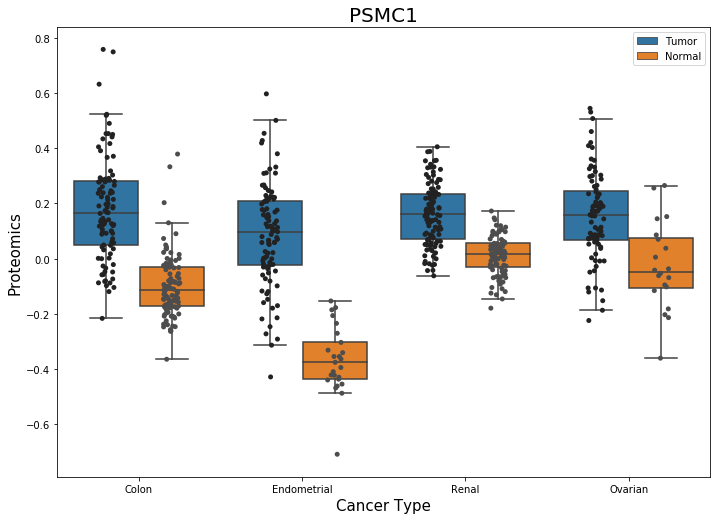

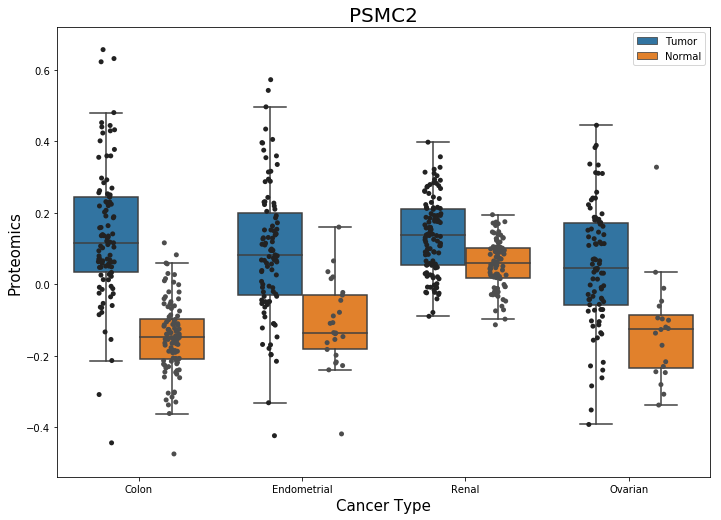

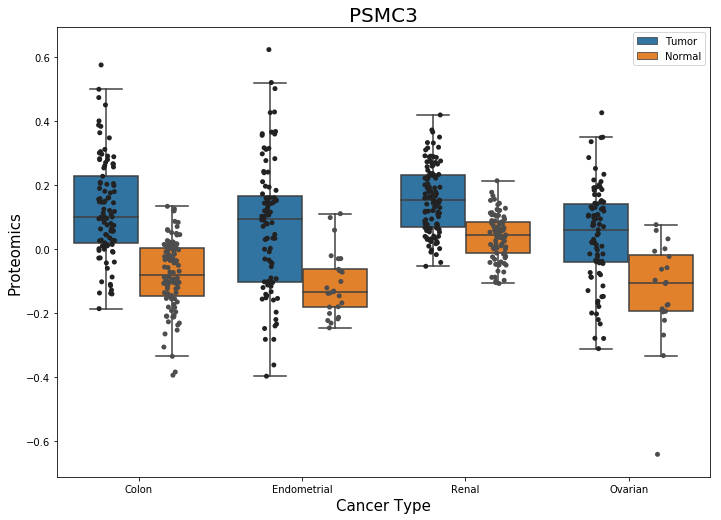

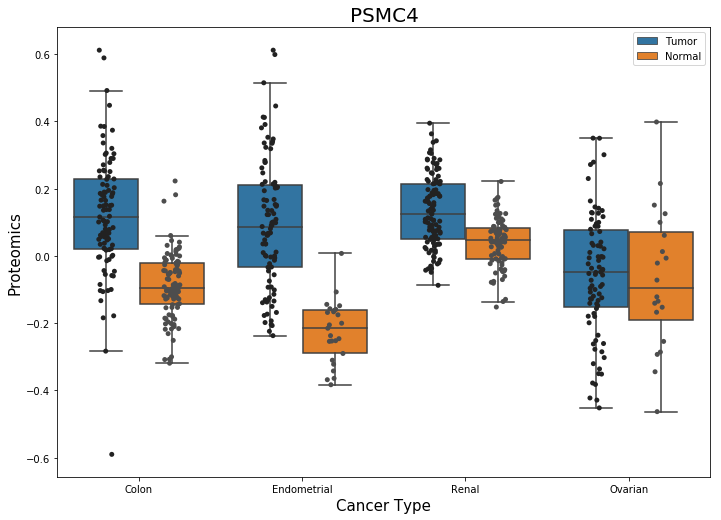

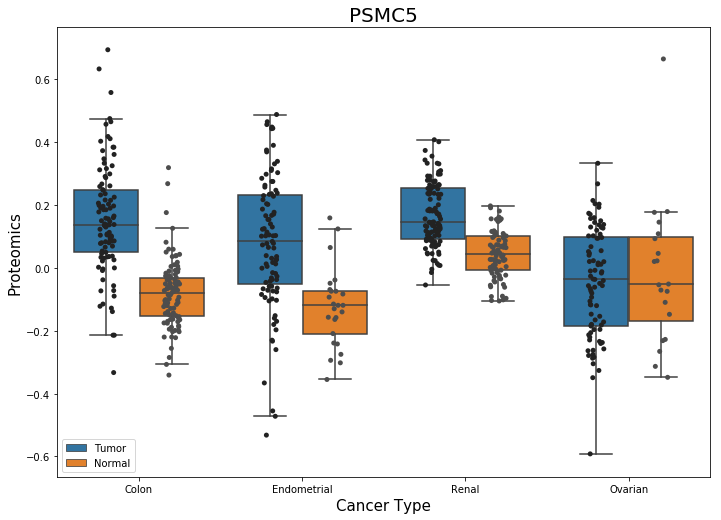

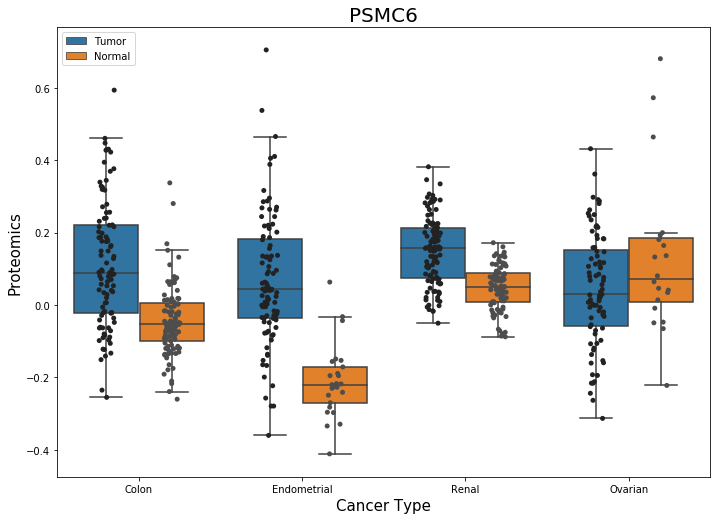

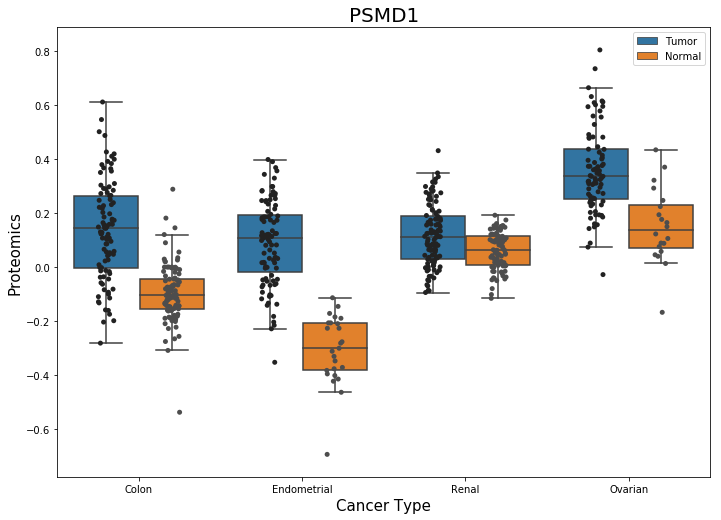

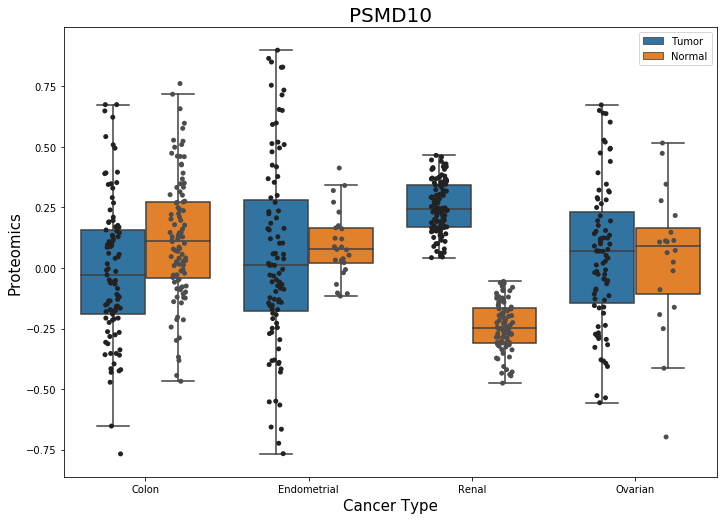

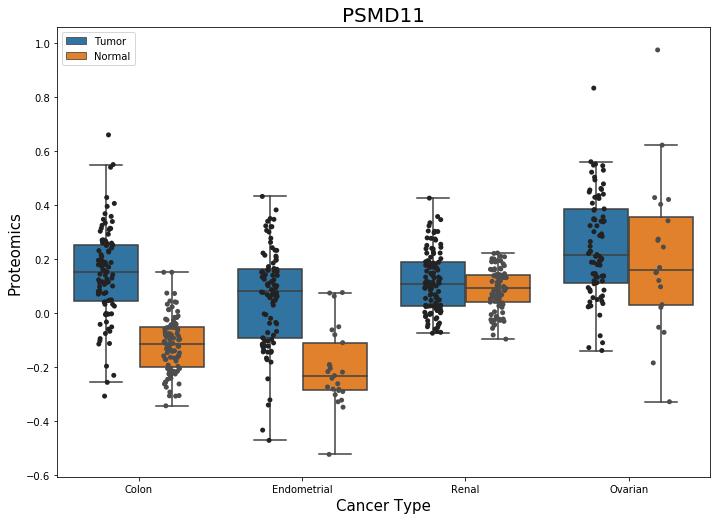

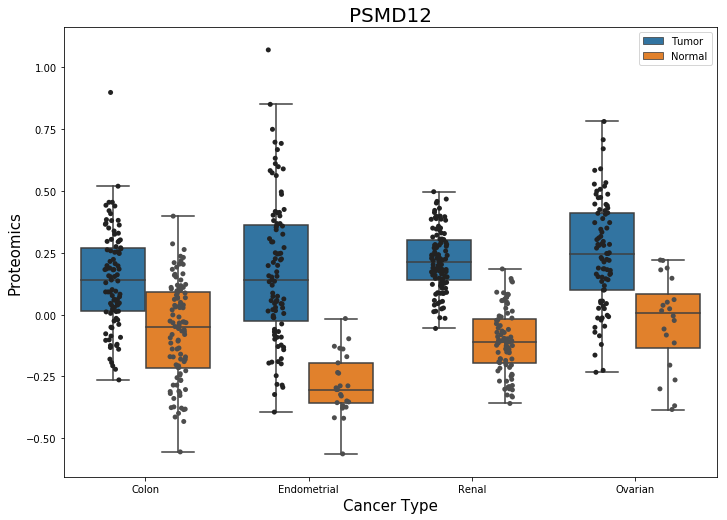

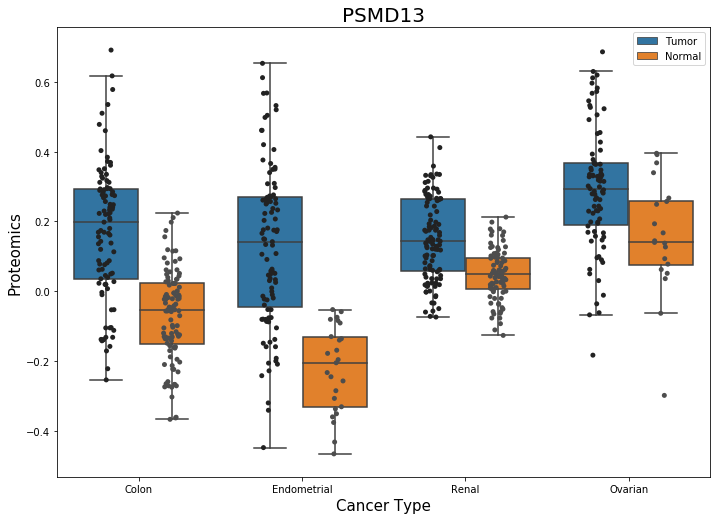

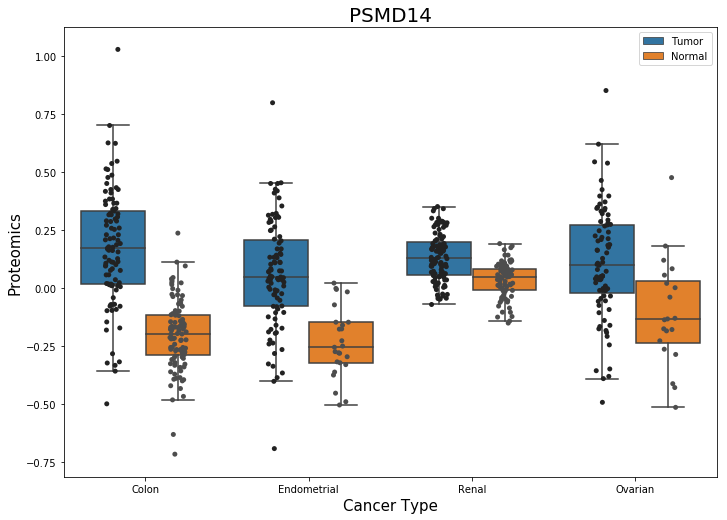

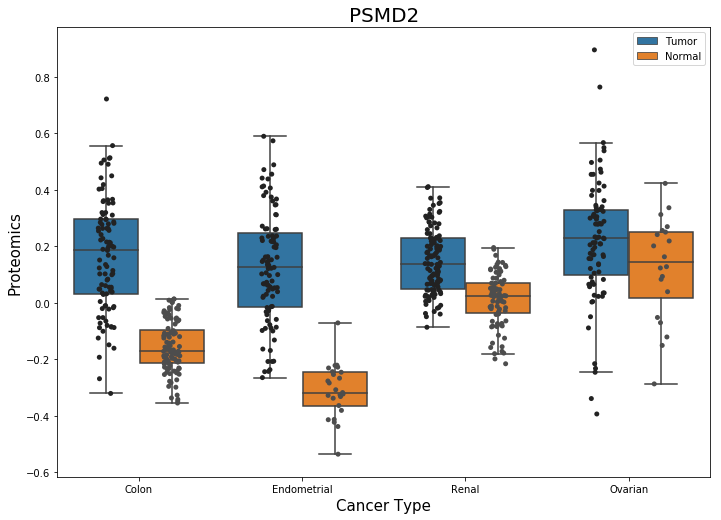

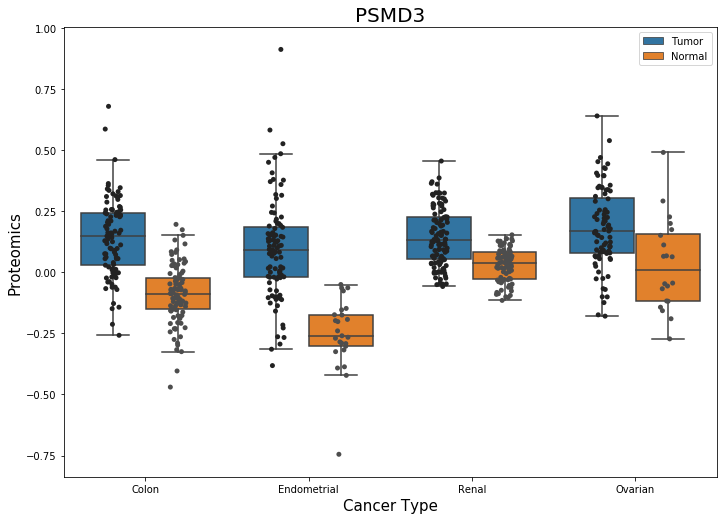

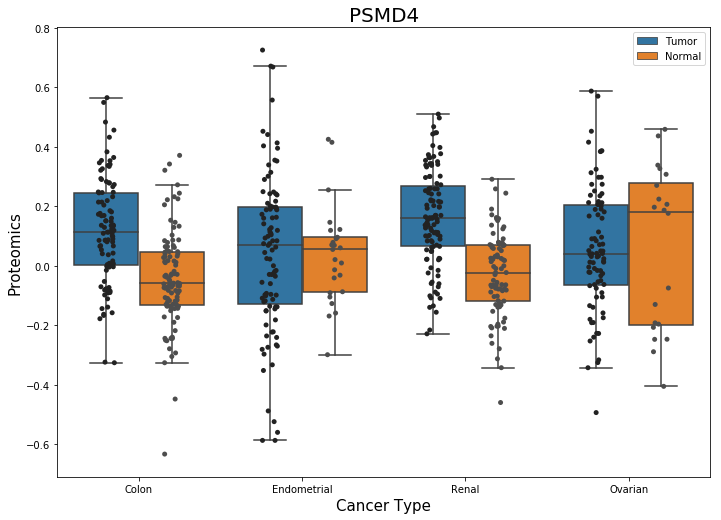

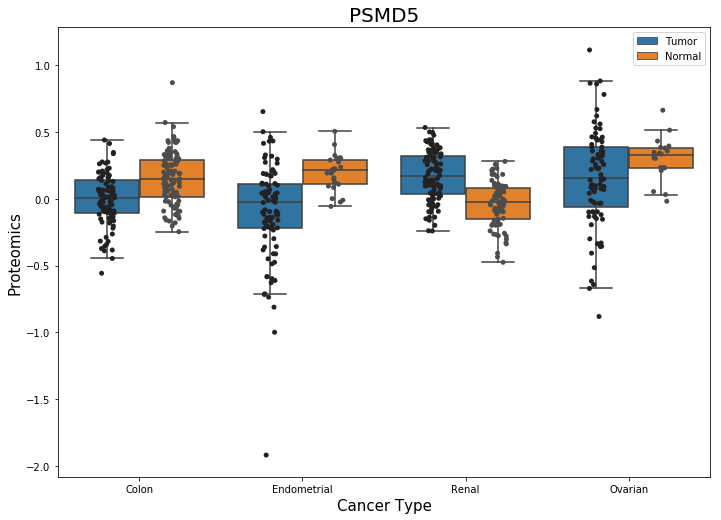

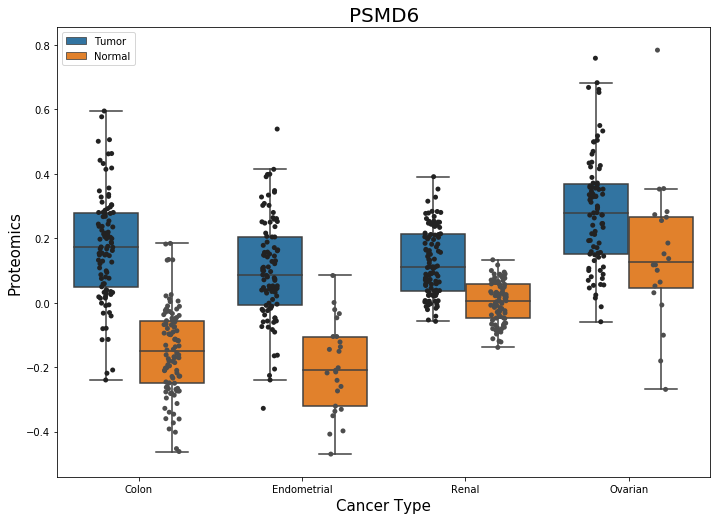

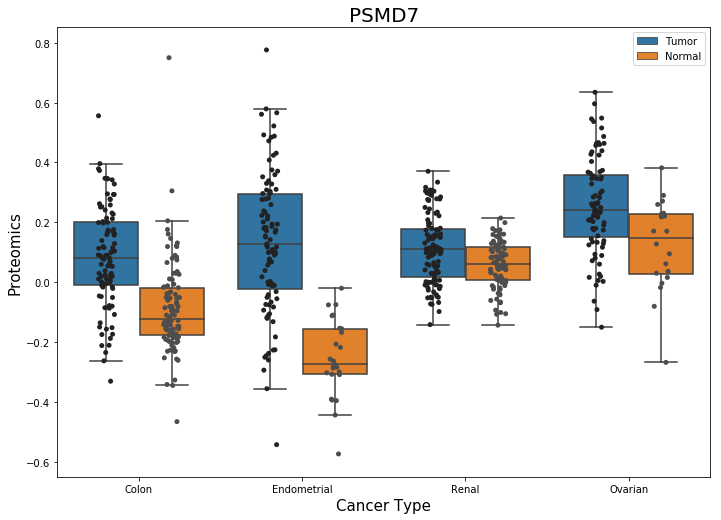

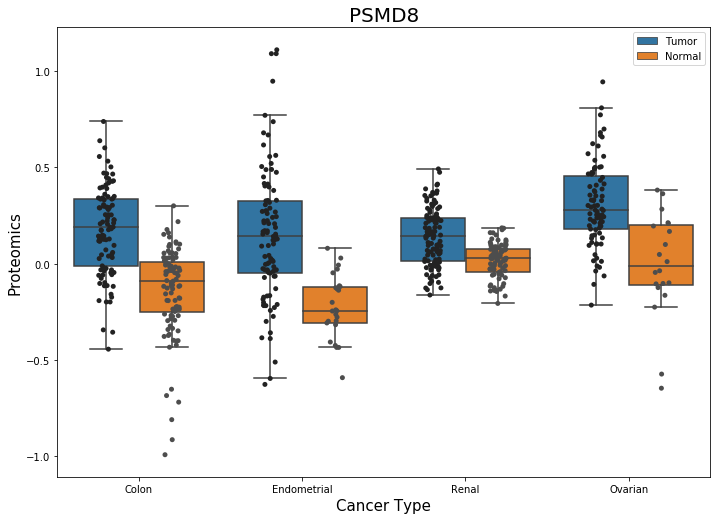

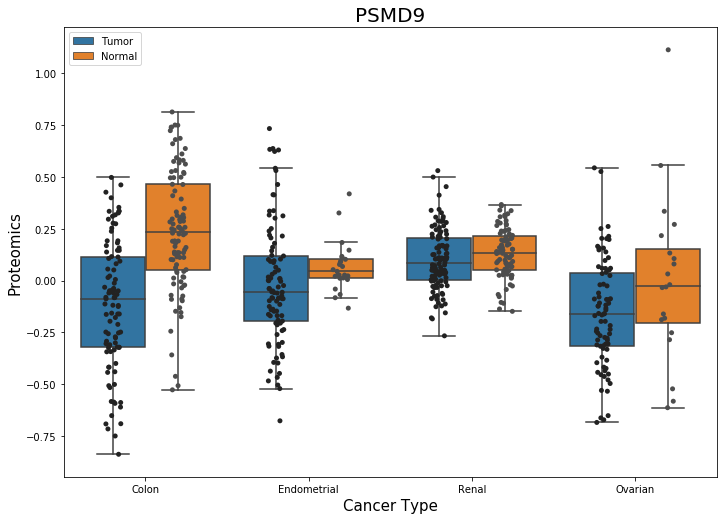

In [12]:
proteasome_proteins = subunitNames['PA700 complex'] + subunitNames['26S proteasome'] + subunitNames['20S proteasome'] + subunitNames['PA28-20S proteasome'] + subunitNames['PA700-20S-PA28 complex'] + subunitNames['PA28gamma-20S proteasome']
proteasome_proteins = list(set(proteasome_proteins))
sub_20s = []
sub_19s = []
pa28 = []
for protein in proteasome_proteins:
    if 'PSMA' in protein or 'PSMB' in protein: sub_20s.append(protein)
    elif 'PSMC' in protein or 'PSMD' in protein: sub_19s.append(protein)
    else: pa28.append(protein)  

sub_19s.sort()
pancancer_plot_proteins(protein_list = sub_19s, show_ttest = True)

### tidy_split

In [9]:
# Thanks StackOverflow! 
# https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    #df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df